In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
house_df=pd.read_csv('house_price_train.csv ')
#test_df=pd.read_csv('house_price_test.csv ')

In [3]:

#house_df=pd.concat([train_df,test_df],axis=0)
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:



y=house_df['SalePrice']

house_df.drop(columns='SalePrice',inplace=True)




In [5]:
#house_df=house_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [6]:
#missing value cols

missing_df=pd.DataFrame({'count':house_df.isnull().sum(),
                        'percentage':house_df.isnull().sum()/len(house_df)*100})
missing_df.sort_values(by='percentage',ascending=False,inplace=True)
missing_cols=list(missing_df[missing_df['percentage']>40].index)
missing_cols

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

In [7]:
#uni value cols
uni_cols=[]
for col in house_df.columns:
    if len(house_df[col].value_counts())==1 or len(house_df[col].value_counts())==len(house_df):
        uni_cols.append(col)
uni_cols

['Id']

In [8]:
house_df.drop(columns=list(set(missing_cols+uni_cols)),inplace=True)

In [9]:
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV

In [10]:
x_train,x_test,y_train,y_test=train_test_split(house_df,y,test_size=.20,random_state=42)

In [11]:
num_cols=list(house_df.select_dtypes(include=[np.number]).columns)
cat_cols=list(house_df.select_dtypes(include=[np.object]).columns)

In [12]:
for col in num_cols:
    x_train[col]=x_train[col].fillna(x_train[col].mean())
    x_test[col]=x_test[col].fillna(x_train[col].mean())

In [13]:
for col in cat_cols:
    x_train[col]=x_train[col].fillna(x_train[col].mode()[0])
    x_test[col]=x_test[col].fillna(x_train[col].mode()[0])
  

In [14]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
for col in num_cols:
    x_train[col]=scale.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=scale.transform(np.array(x_test[col]).reshape(-1,1))

In [15]:
x_train_oe=pd.get_dummies(x_train[cat_cols])
x_test_oe=pd.get_dummies(x_test[cat_cols])

In [16]:
final_x_train_oe,final_x_test_oe=x_train_oe.align(x_test_oe,axis=1,join='inner',fill_value=0)

In [17]:
final_x_train=pd.concat([final_x_train_oe,x_train[num_cols]],axis=1)
final_x_test=pd.concat([final_x_test_oe,x_test[num_cols]],axis=1)

                         

In [18]:
print('train shape:',final_x_train_oe.shape)
print('test  shape:',final_x_test_oe.shape)

train shape: (1168, 196)
test  shape: (292, 196)


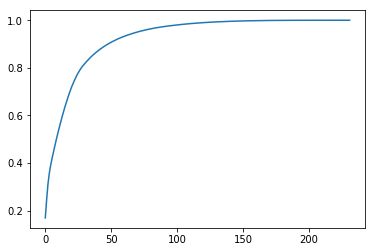

In [19]:
from sklearn.decomposition import PCA
pca=PCA()
x_train_pca=pd.DataFrame(pca.fit_transform(final_x_train))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#x_test_pca=pd.DataFrame(kpca.transform(final_x_test))

In [20]:
pca.explained_variance_ratio_[:80].sum()

0.9628139823972703

In [21]:
from sklearn.decomposition import KernelPCA
pca1= KernelPCA(n_components=80,kernel='rbf')
x_train_pca1=pd.DataFrame(pca1.fit_transform(final_x_train))
#plt.plot(np.cumsum(pca.explained_variance_ratio_))
x_test_pca1=pd.DataFrame(pca1.transform(final_x_test))

In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,accuracy_score,f1_score,r2_score

C:\Users\anish\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


using randomized search

In [23]:
dtr=DecisionTreeRegressor(random_state=42,max_depth=8,min_samples_leaf=16,min_samples_split=8)

dtr.fit(x_train_pca1,y_train)



DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=16,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [ ]:
RF=RandomForestRegressor(bootstrap=True,oob_score=True,n_estimators=200,random_state=42,min_samples_split=12,
                         min_samples_leaf=14,max_depth=8)
RF.fit(x_train_pca1,y_train)


In [ ]:
dtr_pred=dtr.predict(x_test_pca1)
rf_pred=RF.predict(x_test_pca1)

In [ ]:
#print(confusion_matrix(ytest,dtc_pre))
print('DTC train score ',dtr.score(x_train_pca1,y_train))
print('DTC test score',dtr.score(x_test_pca1,y_test))
print("the r2_score of DTC using GCV; ",r2_score(y_test,dtr_pred))

In [ ]:
#print(confusion_matrix(ytest,dtc_pre))
print('RFtrain score ',RF.score(x_train_pca1,y_train))
print('RF test score',RF.score(x_test_pca1,y_test))
print("the r2_score of RF ;\n ",r2_score(y_test,rf_pred))

In [ ]:
stopfrom sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor

In [ ]:

ada=AdaBoostRegressor(random_state=42)
ada_param={'n_estimators':[200],
          'learning_rate':[0.001,1]}
rcv_ada=RandomizedSearchCV(estimator=ada,param_distributions=ada_param,cv=5,n_iter=2)
rcv_ada.fit(final_x_train,y_train)
ada_pre=rcv_ada.predict(final_x_test)
print('bets params:',rcv_ada.best_params_)
print('best score :',rcv_ada.best_score_)


In [ ]:
gradient=GradientBoostingRegressor(random_state=42)
gradient_param={
          'learning_rate':[0.05,0.001],
          'max_depth':[8,12],
          'min_samples_split':[2,6,10],
          'max_features':[0.35,0.75],
          'min_impurity_decrease':[0.001,0.01]}
rcv_gradient=RandomizedSearchCV(cv=5,param_distributions=gradient_param,estimator=gradient,n_iter=43)
rcv_gradient.fit(final_x_train,y_train)
print('best prams:', rcv_gradient.best_params_)
print('best score: ',rcv_gradient.best_score_) 

In [ ]:
ada_pred=rcv_ada.predict(final_x_test)
gradient_pred=rcv_gradient.predict(final_x_test)

In [ ]:
#print(confusion_matrix(ytest,dtc_pre))
print('adaboost train score using grid searchcv',rcv_ada.score(final_x_train,y_train))
print('adaboost test score',rcv_ada.score(final_x_test,y_test))
print("the r2_score of RF using GCV;\n ",r2_score(y_test,ada_pred))

In [ ]:
#print(confusion_matrix(ytest,dtc_pre))
print('gradient_boost train score using grid searchcv',rcv_gradient.score(final_x_train,y_train))
print('gradient_adaboost test score',rcv_gradient.score(final_x_test,y_test))
print("the r2_score of RF using GCV;\n ",r2_score(y_test,gradient_pred))